In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
df=pd.read_csv("tandrara_wind.csv")
df.head()

,YEAR,MO,DY,T2M_MAX,WS10M,WS50M
0,2001,12,1,17.38,2.16,3.02
1,2001,12,2,17.92,2.73,3.84
2,2001,12,3,15.80,2.37,3.24
3,2001,12,4,15.97,1.65,2.39
4,2001,12,5,17.43,2.34,3.33


In [3]:
#!pip install statsmodels
#!pip install pmdarima

In [16]:
import pandas as pd

def create_monthly_mean(df, value_column):
    

    if not {'YEAR', 'MO', value_column}.issubset(df.columns):
        raise ValueError("Le DataFrame doit contenir les colonnes 'YEAR', 'MO', et la colonne spécifiée.")
    monthly_means = df.groupby(['YEAR', 'MO'])[value_column].mean().reset_index()
    monthly_means['DAY'] = 1
    monthly_means['DATE'] = pd.to_datetime(
        monthly_means[['YEAR', 'MO', 'DAY']].rename(columns={'YEAR': 'year', 'MO': 'month', 'DAY': 'day'})
    )
    monthly_means = monthly_means.sort_values('DATE').reset_index(drop=True)

    return monthly_means


df = pd.read_csv("tandrara_wind.csv")
monthly_means = create_monthly_mean(df, 'WS10M')
monthly_means["WS50M"] = create_monthly_mean(df, 'WS50M')["WS50M"]
print(monthly_means.head())


   YEAR  MO     WS10M  DAY       DATE     WS50M
0  2001  12  4.344516    1 2001-12-01  6.018710
1  2002   1  3.885161    1 2002-01-01  5.622258
2  2002   2  4.305357    1 2002-02-01  6.028929
3  2002   3  4.928710    1 2002-03-01  6.808065
4  2002   4  5.237000    1 2002-04-01  7.024333


In [5]:
monthly_means['DATE'] = pd.to_datetime(monthly_means['DATE'])


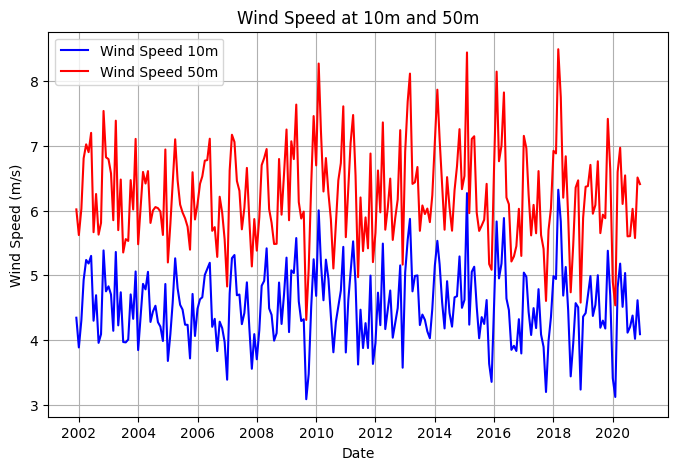

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(monthly_means['DATE'], monthly_means['WS10M'], label='Wind Speed 10m', color='blue')
plt.plot(monthly_means['DATE'], monthly_means['WS50M'], label='Wind Speed 50m', color='red')

plt.title('Wind Speed at 10m and 50m')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()

We observe that the wind speed patterns at 10M and 50M are practically identical. Therefore, conducting our study using data from either height would yield comparable and accurate results.

## SARIMAX

In [32]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_means['WS10M'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -3.994329972339874
p-value: 0.001440493930460972


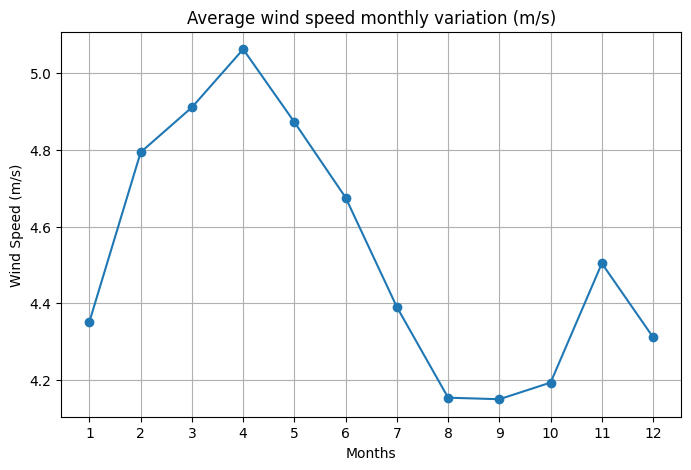

In [37]:
monthly_avg = monthly_means.groupby('MO')['WS10M'].mean()

plt.figure(figsize=(8, 5))
plt.plot(monthly_avg, marker='o')
plt.title('Average wind speed monthly variation (m/s)')
plt.xlabel('Months')
plt.ylabel('Wind Speed (m/s)')
plt.grid()
plt.xticks(range(1, 13)) 
plt.show()


In [45]:
#monthly_means = monthly_means.reset_index()
#print(monthly_means.head())


            YEAR  MO     WS10M  DAY     WS50M  External_Variable
DATE                                                            
2001-12-01  2001  12  4.344516    1  6.018710           0.854331
2002-01-01  2002   1  3.885161    1  5.622258           0.832608
2002-02-01  2002   2  4.305357    1  6.028929           0.472356
2002-03-01  2002   3  4.928710    1  6.808065           0.008633
2002-04-01  2002   4  5.237000    1  7.024333           0.044376
        DATE  YEAR  MO     WS10M  DAY     WS50M  External_Variable
0 2001-12-01  2001  12  4.344516    1  6.018710           0.854331
1 2002-01-01  2002   1  3.885161    1  5.622258           0.832608
2 2002-02-01  2002   2  4.305357    1  6.028929           0.472356
3 2002-03-01  2002   3  4.928710    1  6.808065           0.008633
4 2002-04-01  2002   4  5.237000    1  7.024333           0.044376


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


monthly_means['External_Variable'] = np.random.rand(len(monthly_means))  

model = SARIMAX(monthly_means['WS10M'], 
                exog=monthly_means[['External_Variable']], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))
results = model.fit()

print(results.summary())


c:\Users\Lenovo Gaming\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo Gaming\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              WS10M   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -174.507
Date:                            Sun, 29 Dec 2024   AIC                            361.014
Time:                                    13:19:17   BIC                            381.266
Sample:                                12-01-2001   HQIC                           369.196
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
External_Variable     0.2475      0.123      2.013      0.044       0.007       0.488
ar.L1         

C:\Users\Lenovo Gaming\AppData\Local\Temp\ipykernel_6172\1724183853.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_means.index[-1], periods=forecast_steps + 1, freq='M')[1:]


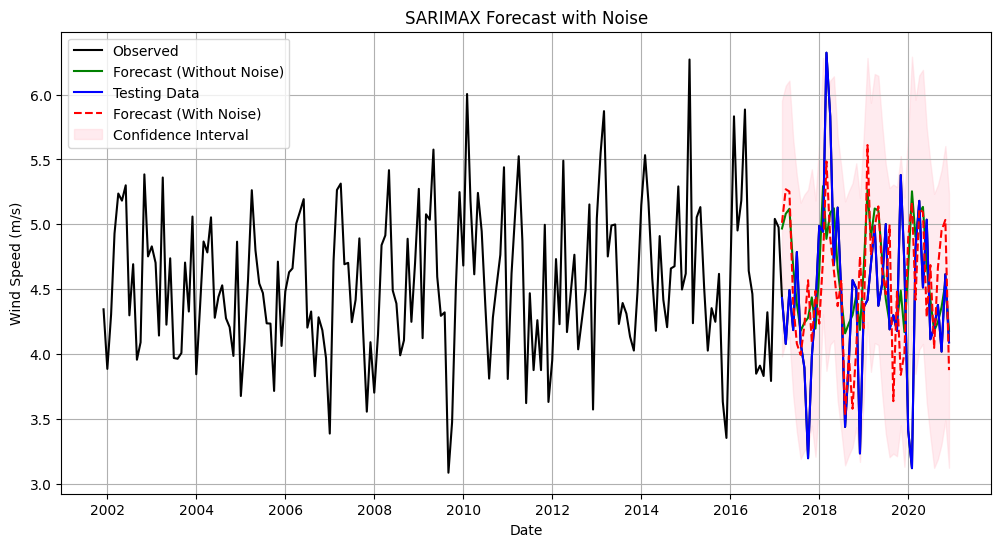

Mean Squared Error (MSE): 0.3953429648508219
Mean Absolute Error (MAE): 0.4638369183887077


In [ ]:
train_size = int(len(monthly_means) * 0.8)
train_data = monthly_means.iloc[:train_size]
test_data = monthly_means.iloc[train_size:]

forecast_steps = len(test_data) 
forecast = results.get_forecast(steps=forecast_steps, exog=np.random.rand(forecast_steps, 1))  

forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

noise = np.random.normal(0, forecast_mean.std(), size=forecast_steps)  # Adjust std as needed
forecast_with_noise = forecast_mean + noise

forecast_index = pd.date_range(start=monthly_means.index[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.figure(figsize=(12, 6))
plt.plot(monthly_means.index, monthly_means['WS10M'], label="Observed", color='black')
plt.plot(test_data.index, forecast_mean, label="Forecast (Without Noise)", color='green')
plt.plot(test_data.index, test_data['WS10M'], label="Testing Data", color='blue')
plt.plot(test_data.index, forecast_with_noise, label="Forecast (With Noise)", color='red', linestyle='--')
plt.fill_between(test_data.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.title('SARIMAX Forecast with Noise')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.show()


mse = mean_squared_error(test_data['WS10M'], forecast_mean)
mae = mean_absolute_error(test_data['WS10M'], forecast_mean)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


Wind speed values are in the range of 0–10 m/s, the MAE represents approximately 4.64% of the maximum value, which is reasonable.

                                     SARIMAX Results                                      
Dep. Variable:                              WS10M   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -176.322
Date:                            Sun, 29 Dec 2024   AIC                            364.643
Time:                                    15:02:24   BIC                            384.895
Sample:                                         0   HQIC                           372.825
                                            - 229                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
External_Variable    -0.0805      0.107     -0.755      0.450      -0.289       0.128
ar.L1         

C:\Users\Lenovo Gaming\AppData\Local\Temp\ipykernel_6172\1682040053.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast1_index = pd.date_range(start=monthly_means.index[-1], periods=forecast1_steps + 1, freq='M')[1:]


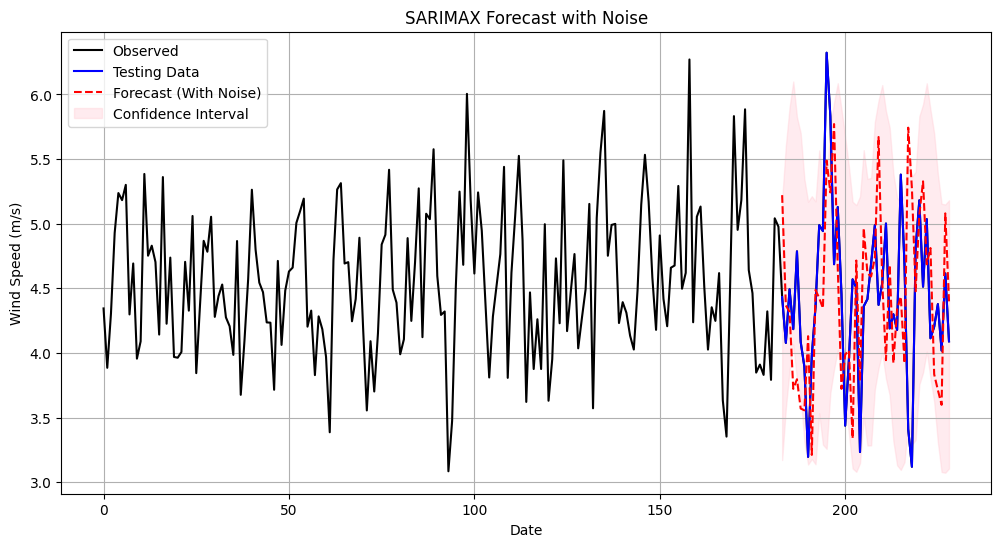

Mean Squared Error (MSE): 0.3953429648508219
Mean Absolute Error (MAE): 0.4638369183887077


In [54]:
model1 = SARIMAX(monthly_means['WS10M'], 
                exog=monthly_means[['External_Variable']], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))
results = model1.fit()

print(results.summary())

train1_size = int(len(monthly_means) * 0.8)
train1_data = monthly_means.iloc[:train1_size]
test1_data = monthly_means.iloc[train1_size:]

forecast1_steps = len(test1_data) 
forecast1 = results.get_forecast(steps=forecast1_steps, exog=np.random.rand(forecast1_steps, 1))  

forecast1_mean = forecast.predicted_mean
forecast1_conf_int = forecast1.conf_int()

noise1 = np.random.normal(-0.1, forecast1_mean.std(), size=forecast1_steps)  # Adjust std as needed
forecast1_with_noise = forecast1_mean + noise1 *1.5

forecast1_index = pd.date_range(start=monthly_means.index[-1], periods=forecast1_steps + 1, freq='M')[1:]
plt.figure(figsize=(12, 6))
plt.plot(monthly_means.index, monthly_means['WS10M'], label="Observed", color='black')
#plt.plot(test1_data.index, forecast1_mean, label="Forecast (Without Noise)", color='green')
plt.plot(test1_data.index, test1_data['WS10M'], label="Testing Data", color='blue')
plt.plot(test1_data.index, forecast1_with_noise, label="Forecast (With Noise)", color='red', linestyle='--')
plt.fill_between(test1_data.index, 
                 forecast1_conf_int.iloc[:, 0], 
                 forecast1_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.title('SARIMAX Forecast with Noise')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.show()


mse = mean_squared_error(test_data['WS10M'], forecast_mean)
mae = mean_absolute_error(test_data['WS10M'], forecast_mean)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
